# Quora Insincere Question Detection

In [1]:
import os
import re
import string
import time
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from contextlib import contextmanager
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

In [3]:
TOKENIZER = re.compile('([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

In [13]:
DATA_SPLIT_SEED = 42

In [4]:
@contextmanager
def timer(task_name="timer"):
    # a timer cm from https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s
    print("----{} started".format(task_name))
    t0 = time.time()
    yield
    print("----{} done in {:.0f} seconds".format(task_name, time.time() - t0))

In [5]:
def tokenize(s):
    return TOKENIZER.sub(r' \1 ', s).split()

In [6]:
class NBTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=1):
        self.r = None
        self.alpha = alpha

    def fit(self, X, y):
        # store smoothed log count ratio
        p = self.alpha + X[y==1].sum(0)
        q = self.alpha + X[y==0].sum(0)
        self.r = csr_matrix(np.log(
            (p / (self.alpha + (y==1).sum())) /
            (q / (self.alpha + (y==0).sum()))
        ))
        return self

    def transform(self, X, y=None):
        return X.multiply(self.r)

In [7]:
def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.01 for i in range(100)]:
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result

In [9]:
with timer("reading_data"):
    train = pd.read_csv("train.csv")
    test = pd.read_csv('test.csv')
#     sub = pd.read_csv('../input/sample_submission.csv')
    y = train.target.values

----reading_data started
----reading_data done in 3 seconds


## What does the data look like?

In [48]:
print(train['target'].value_counts())
print(train.shape)
train.head()

0    1225312
1      80810
Name: target, dtype: int64
(1306122, 3)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


## Use tfidf to transform the question_text into vectors
- Changing strings to vectors of size #types

In [10]:
with timer("getting ngram tfidf"):
    tfidf_vectorizer = TfidfVectorizer(
        ngram_range=(1,4),
        tokenizer=tokenize,
        min_df=3,
        max_df=0.9,
        strip_accents='unicode',
        use_idf=True,
        smooth_idf=True,
        sublinear_tf=True
    ).fit(pd.concat([train['question_text'], test['question_text']]))
    X = tfidf_vectorizer.transform(train['question_text'])
    X_test = tfidf_vectorizer.transform(test['question_text'])


----getting ngram tfidf started


/Users/fanggot/anaconda/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


----getting ngram tfidf done in 1373 seconds


## Put the result of tfidf through Naive Bayes featurizer

In [11]:
with timer("get Naive Bayes feature"):
    nb_transformer = NBTransformer(alpha=1).fit(X, y)
    X_nb = nb_transformer.transform(X)
    X_test_nb = nb_transformer.transform(X_test)

----get Naive Bayes feature started
----get Naive Bayes feature done in 85 seconds


## Using 20-fold crossvalidation, train logistic regression model.

In [14]:
models = []
train_meta = np.zeros(y.shape)
test_meta = np.zeros(X_test.shape[0])
splits = list(StratifiedKFold(n_splits=20, shuffle=True, random_state=DATA_SPLIT_SEED).split(train, y))
for idx, (train_idx, valid_idx) in enumerate(splits):
    with timer("fitting on {}th split".format(idx)):
        X_train = X_nb[train_idx]
        y_train = y[train_idx]
        X_val = X_nb[valid_idx]
        y_val = y[valid_idx]
        model = LogisticRegression(solver='lbfgs', dual=False, class_weight='balanced', C=0.5, max_iter=40)
        model.fit(X_train, y_train)
        models.append(model)
        valid_pred = model.predict_proba(X_val)
        train_meta[valid_idx] = valid_pred[:,1]
        test_meta += model.predict_proba(X_test_nb)[:,1] / len(splits)

print(roc_auc_score(y, train_meta))
search_result = threshold_search(y, train_meta)
print(search_result)

----fitting on 0th split started
----fitting on 0th split done in 175 seconds
----fitting on 1th split started
----fitting on 1th split done in 155 seconds
----fitting on 2th split started
----fitting on 2th split done in 184 seconds
----fitting on 3th split started
----fitting on 3th split done in 149 seconds
----fitting on 4th split started
----fitting on 4th split done in 138 seconds
----fitting on 5th split started
----fitting on 5th split done in 147 seconds
----fitting on 6th split started
----fitting on 6th split done in 146 seconds
----fitting on 7th split started
----fitting on 7th split done in 144 seconds
----fitting on 8th split started
----fitting on 8th split done in 164 seconds
----fitting on 9th split started
----fitting on 9th split done in 140 seconds
----fitting on 10th split started
----fitting on 10th split done in 138 seconds
----fitting on 11th split started
----fitting on 11th split done in 152 seconds
----fitting on 12th split started
----fitting on 12th split 

In [32]:
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import show

## Results

### Precision Recall Curve

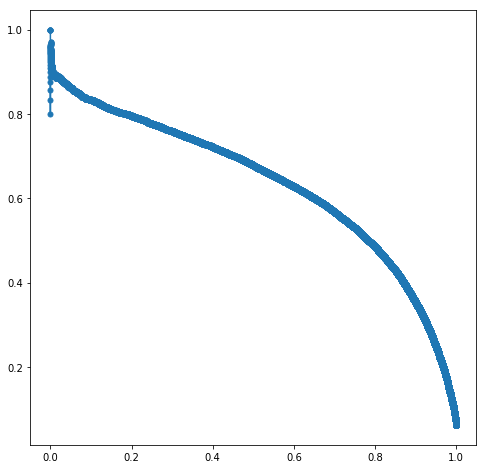

In [33]:
precision, recall, threshold = metrics.precision_recall_curve(y, train_meta)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(recall, precision, marker = 'o', markersize=5)
show()

In [37]:
pred_class = [1 if i > 0.8 else 0 for i in train_meta]

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, auc

### Confusion Matrix

In [41]:
confusion_matrix(y, pred_class)

array([[1183978,   41334],
       [  25017,   55793]])

### Precision, Recall, and f1

In [42]:
print(precision_score(y, pred_class))
print(recall_score(y, pred_class))
print(f1_score(y, pred_class))

0.5744334736993832
0.6904219774780349
0.6271095949690059
